
# 📘 **Rusty Bargain — Estimating Market Value of Vehicles**

<div style="font-size:12px0;"

---

## 📚 **Index**

- [🚀 **1. Project Overview**](#1-project-overview)
- [🗂️ **2. Data Preparation**](#2-data-preparation)
  - [📥 2.1 Loading and Initial Data Exploration](#21-loading-and-initial-data-exploration)
  - [🧹 2.2 Cleaning & Feature Engineering](#22-cleaning--feature-engineering)
- [🧠 **3. Model Training**](#3-model-training)
  - [📏 3.1 Baseline Model — Linear Regression](#31-baseline-model--linear-regression)
  - [🌳 3.2 Decision Tree Regressor](#32-decision-tree-regressor)
  - [🌲 3.3 Random Forest Regressor ](#33-random-forest-regressor)
  - [⚡ 3.4 LightGBM Regressor](#34-lightgbm-regressor)
  - [🐱 3.5 CatBoost Regressor](#35-catboost-regressor)
- [📊 **4. Final Model Comparison**](#4-final-model-comparison-rmse-results)
- [🧾 **5. Conclusions**](#5-conclusions)

></div>

---
# 🚀 **1. Project Overview**
<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">



Rusty Bargain — a used car sales service — is developing an app to estimate **the market value of vehicles** based on historical listings. <br>

The dataset contains **technical specifications, trims, and prices**, and our goal is to build and compare models that predict the **Price (EUR)** of a car accurately and efficiently.

## 🎯 **Project Objectives**

Rusty Bargain is interested in three key aspects:
1. **Prediction quality** — measured by the RMSE metric.  
2. **Training time** — total time to fit the model.
3. **Prediction speed** — how fast the model produces outputs.  

✅ **Success Criteria:** Achieve a competitive RMSE compared to baseline models while maintaining reasonable training and inference times.

---

## 🗂️ **Data Description**

**File:** `/datasets/car_data.csv`  
**Target:** `Price` (EUR)  
**Main features:**  
`DateCrawled`, `VehicleType`, `RegistrationYear`, `Gearbox`, `Power`, `Model`,  
`Mileage`, `RegistrationMonth`, `FuelType`, `Brand`, `NotRepaired`,  
`DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`.

</div>


In [1]:
# 🚀 Import all required libraries

# Core
import sys, platform
import time
import pandas as pd
import numpy as np
import sklearn

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Gradient Boosting libraries
import lightgbm as lgb
import catboost as cb
import xgboost as xgb

# Evaluation metrics
from sklearn.metrics import mean_squared_error


# Environment check

print("OS:", platform.platform())
print('Python:', sys.version)
print('Pandas:', pd.__version__)
print('NumPy:', np.__version__)
print('Seaborn:', sns.__version__)
print('sklearn:',sklearn.__version__)
#print('LightGBM:', lgb.__version__)

OS: Linux-6.1.155-176.282.amzn2023.x86_64-x86_64-with-glibc2.36
Python: 3.9.23 (main, Jul 22 2025, 01:40:31) 
[GCC 12.2.0]
Pandas: 1.2.4
NumPy: 1.21.2
Seaborn: 0.11.1
sklearn: 0.24.1



# **📊 2. Data Preparation**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">
➡️ In this section, we will load, inspect, and preprocess the dataset to ensure it is ready for modeling. <br>
The steps include:<br>
    
- Loading the data and reviewing its structure.
- Checking for missing values, duplicates, and outliers.  
- Exploring distributions and relationships between key variables.  
- Engineering and encoding features as needed for different model families (linear, tree-based, and gradient boosting).  
- Splitting the data into training. validation and test sets to enable fair performance comparison later.

</div>

### **📥 2.1. Loading and Initial Data Exploration**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">
➡️ First, we load the dataset and perform a basic inspection to understand its structure, dimensions, and types of variables before diving into deeper analysis.
</div>

In [2]:
# 📥 Load the data set 
df = pd.read_csv('/datasets/car_data.csv')

In [3]:
# Basic overview of structure and size

print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}\n')

Number of rows: 354369
Number of columns: 16



In [4]:
# Display general information
print('--- Dataset Info ---')
print(df.info())
print('\n--- Preview (first 5 rows) ---')
display(df.head())

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtyp

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [5]:
# Explore missing values and calculate its percentage
print('\n--- Missing Values Summary ---')
missing_summary = df.isnull().sum()
missing_percentage = (missing_summary / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_summary, 'Percentage (%)': missing_percentage})
print(missing_df[missing_df['Missing Values'] > 0])


--- Missing Values Summary ---
             Missing Values  Percentage (%)
VehicleType           37490       10.579368
Gearbox               19833        5.596709
Model                 19705        5.560588
FuelType              32895        9.282697
NotRepaired           71154       20.079070


In [6]:
# Identify duplicate rows 
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 262


In [7]:
#Identify data types and unique values in each column
for col in df.columns:
    print(f"{col}: {df[col].dtype}, Unique values: {df[col].nunique()}")

DateCrawled: object, Unique values: 15470
Price: int64, Unique values: 3731
VehicleType: object, Unique values: 8
RegistrationYear: int64, Unique values: 151
Gearbox: object, Unique values: 2
Power: int64, Unique values: 712
Model: object, Unique values: 250
Mileage: int64, Unique values: 13
RegistrationMonth: int64, Unique values: 13
FuelType: object, Unique values: 7
Brand: object, Unique values: 40
NotRepaired: object, Unique values: 2
DateCreated: object, Unique values: 109
NumberOfPictures: int64, Unique values: 1
PostalCode: int64, Unique values: 8143
LastSeen: object, Unique values: 18592


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">
🔎 The column <b>NumberOfPictures</b> contains a single constant value (<code>0</code>) across all rows and provides no informational value for modeling. <br> 
🔎 The column <b>PostalCode</b> contains a very high number of unique values (8,143) and represents the user’s location rather than a car attribute.
</div>

In [8]:
# identify anomalies in specific columns
# 'RegistrationMonth' 

unique_months = sorted(map(int, df['RegistrationMonth'].unique()))
print("Unique values in RegistrationMonth column (sorted):", unique_months)
print(f"Number of 0 values in RegistrationMonth colum:", (df['RegistrationMonth']==0).sum())
print(f"Percentage of 0 values in RegistrationMonth colum:", (df['RegistrationMonth']==0).mean()*100)


Unique values in RegistrationMonth column (sorted): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Number of 0 values in RegistrationMonth colum: 37352
Percentage of 0 values in RegistrationMonth colum: 10.540425375808832


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">
🔎 The variable <b>RegistrationMonth</b> includes an anomalous value (<code>0</code>) representing 10.54% of the data, which likely encodes missing or unknown months.
</div>

In [9]:
#Date created analysis
df['DateCreated'].describe()

count               354369
unique                 109
top       03/04/2016 00:00
freq                 13719
Name: DateCreated, dtype: object

In [10]:
# 'RegistrationYear' 

unique_years = sorted(map(int, df['RegistrationYear'].unique()))
years_below_1900 = [year for year in unique_years if year < 1900]
years_above_2016 = [year for year in unique_years if year > 2016]

print("🕒 Years below 1900:")
print(years_below_1900)

print("\n🚀 Years above 2016:")
print(years_above_2016)

🕒 Years below 1900:
[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800]

🚀 Years above 2016:
[2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">
🔎 The variable <b>RegistrationYear</b> contains unrealistic values before <code>1900</code> and after <code>2016</code>, which are impossible given the context of the date of profiles created on the data set (top date: 2016). 
</div>

In [11]:
# Mileage 
unique_mileage = sorted(map(int, df['Mileage'].unique()))
print("Unique values in Mileage column (sorted):", unique_mileage)
df['Mileage'].value_counts().sort_index()


Unique values in Mileage column (sorted): [5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 125000, 150000]


5000        6397
10000       1222
20000       3975
30000       4436
40000       4911
50000       6232
60000       7444
70000       8593
80000      10047
90000      11567
100000     14882
125000     36454
150000    238209
Name: Mileage, dtype: int64

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">
🔎 The variable <b>Mileage</b> shows only 13 discrete values, grouped in 10 000 km increments. 
</div>

In [12]:
# Power
unique_powers = sorted(map(int, df['Power'].unique()))
powers_below_10 = [power for power in unique_powers if power < 10]
powers_above_1000 = [power for power in unique_powers if power > 1000]
print("⚡ Powers below 10:")
print(powers_below_10)  
print("\n💥 Powers above 1000:")
print(powers_above_1000)

⚡ Powers below 10:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

💥 Powers above 1000:
[1001, 1002, 1003, 1004, 1005, 1011, 1012, 1016, 1017, 1021, 1024, 1054, 1055, 1056, 1062, 1079, 1082, 1090, 1100, 1102, 1103, 1105, 1111, 1115, 1120, 1149, 1151, 1158, 1160, 1162, 1164, 1199, 1200, 1202, 1221, 1223, 1230, 1239, 1240, 1241, 1250, 1252, 1256, 1275, 1288, 1299, 1300, 1312, 1317, 1324, 1339, 1351, 1360, 1362, 1363, 1367, 1390, 1394, 1398, 1399, 1400, 1401, 1403, 1405, 1416, 1432, 1433, 1436, 1500, 1501, 1502, 1503, 1506, 1521, 1548, 1595, 1596, 1597, 1598, 1600, 1625, 1631, 1653, 1659, 1689, 1700, 1701, 1703, 1704, 1707, 1753, 1771, 1779, 1780, 1781, 1783, 1793, 1796, 1799, 1800, 1801, 1870, 1895, 1896, 1900, 1910, 1920, 1922, 1933, 1937, 1968, 1986, 1988, 1992, 1993, 1995, 1998, 1999, 2000, 2004, 2005, 2007, 2009, 2016, 2017, 2018, 2172, 2200, 2201, 2331, 2340, 2389, 2402, 2461, 2598, 2729, 2789, 2792, 2799, 3000, 3199, 3454, 3500, 3750, 4400, 4507, 4700, 5000, 5411, 5420, 5575, 5809, 5815, 5867, 600

In [13]:
df_high_power = df[df['Power'] > 1000][['Brand', 'Model', 'RegistrationYear', 'FuelType', 'Power', 'Price']]
display(df_high_power.sort_values('Power', ascending=False).head(20))

,Brand,Model,RegistrationYear,FuelType,Power,Price
219584,mercedes_benz,clk,1999,petrol,20000,4300
299180,bmw,5er,1997,NaN,19312,1500
114106,bmw,1er,2006,gasoline,19211,9999
132485,bmw,5er,2001,NaN,19208,2100
63986,opel,omega,2001,petrol,17932,3250
196532,bmw,5er,2004,gasoline,17700,6000
150676,audi,80,1995,petrol,17410,1700
187330,bmw,3er,1989,petrol,17019,1749
175422,audi,a3,2007,gasoline,17011,10900
216993,audi,a4,2008,petrol,16312,11950


In [14]:
# Filter cars with Power between 1000 and 1200 hp
df_mid_power = df[(df['Power'] >= 1000) & (df['Power'] <= 1200)][
    ['Brand', 'Model', 'RegistrationYear', 'FuelType', 'Power', 'Price']
]

# Display sorted by Power descending
display(df_mid_power.sort_values('Power', ascending=False).head(20))

,Brand,Model,RegistrationYear,FuelType,Power,Price
21609,lancia,NaN,2000,petrol,1200,200
66621,fiat,punto,1200,petrol,1200,0
200450,opel,corsa,2002,petrol,1199,850
98262,ford,galaxy,2005,gasoline,1164,2600
203427,volvo,v40,2000,petrol,1162,1000
270974,bmw,3er,1996,petrol,1160,800
236059,opel,vectra,2016,petrol,1158,399
157954,volkswagen,sharan,1997,petrol,1151,1000
281847,renault,twingo,2002,petrol,1149,1150
205634,ford,NaN,1996,petrol,1120,250


In [15]:
df_low_power = df[df['Power'] < 10][['Brand', 'Model', 'RegistrationYear', 'FuelType', 'Power', 'Price']]
display(df_low_power.sort_values('Power', ascending=False).head(20))

,Brand,Model,RegistrationYear,FuelType,Power,Price
122963,sonstige_autos,NaN,1956,petrol,9,4500
339754,sonstige_autos,NaN,2008,petrol,9,2000
273708,fiat,NaN,1991,petrol,9,200
37733,citroen,other,1999,petrol,9,1300
138372,opel,other,1980,NaN,9,5200
324049,citroen,c3,1923,petrol,8,8750
353127,sonstige_autos,NaN,2012,gasoline,8,8600
75921,sonstige_autos,NaN,2009,NaN,8,700
336260,volkswagen,golf,2011,gasoline,8,9299
138158,opel,astra,1999,gasoline,8,1350


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">
🔎 The <b>Power</b> variable was examined across low, mid, and high ranges. Manual inspection confirmed that entries below <code>30 hp</code> and above <code>1000 hp</code> correspond to implausible values.  
</div>

In [16]:
# Fuel type 
unique_fuel_types = df['FuelType'].unique()
print("Unique Fuel Types in the dataset:", unique_fuel_types)

Unique Fuel Types in the dataset: ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">
🔎 The <b>FuelType</b> variable includes eight categories. The terms <code>petrol</code> and <code>gasoline</code> refer to the same fuel and will be merged. 
</div>


--- Descriptive Statistics (Price) ---


count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

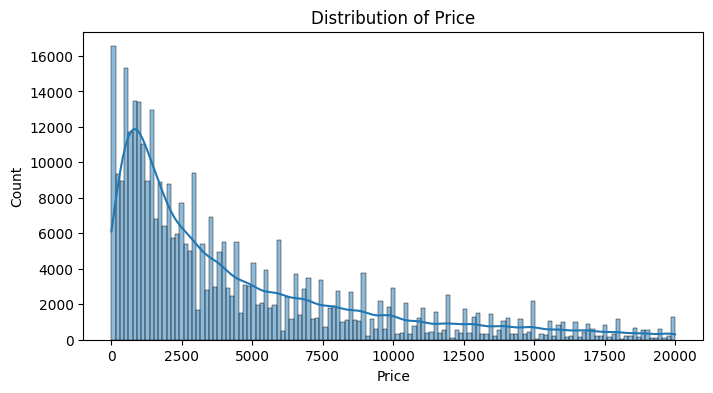

💲 Number of rows with Price < 100: 13314
📉 Percentage of total: 3.76%


In [17]:
# Descriptive statistics for Price column (target variable)
print('\n--- Descriptive Statistics (Price) ---')
display(df['Price'].describe().T)

plt.figure(figsize=(8, 4))
sns.histplot(df['Price'].dropna(), kde=True)
plt.title(f'Distribution of Price')
plt.show()

count_below_100 = (df['Price'] < 100).sum()
pct_below_100 = (df['Price'] < 100).mean() * 100

print(f"💲 Number of rows with Price < 100: {count_below_100}")
print(f"📉 Percentage of total: {pct_below_100:.2f}%")

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">
🔎 The target variable <b>Price</b> shows a strong right-skewed distribution, with most vehicles priced below 10 000 €.  
A total of <b>13,314 listings</b> with unrealistic prices below 100 € were identified.
</div>

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

##### 🔎 **2.1. Loading and Initial Data Exploration — Findings**

- The dataset contains **354,369 rows** and **14 columns**, with `Price` as the target variable.  
- Several features (`VehicleType`, `Gearbox`, `Model`, `FuelType`, and `NotRepaired`) include missing values ranging from **5% to 20%**.  
- Temporal features (`DateCrawled`, `DateCreated`, `LastSeen`) require conversion to `datetime`, while `PostalCode` should be treated as a categorical (`object`) variable.  
- **RegistrationMonth** contains an invalid value `0` (≈10.5% of entries), representing missing data.  
- **RegistrationYear** includes impossible values before `1900` and after `2016`.  
- **Mileage** is discretized into 13 bins of 10 000 km increments, with most cars exceeding 125 000 km.  
- **Power** shows clear anomalies:
  - Unrealistic low values (<30 hp) and extreme outliers (>1000 hp).
  - Manual inspection confirmed that such cases correspond to placeholder or incorrect entries.
- **FuelType** includes overlapping categories (`petrol`/`gasoline`) and missing values (≈9.3%).  
- **Gearbox** presents two valid categories (`manual`, `auto`) with minor missing data.  
- **VehicleType** includes valid body types but also `other` and missing entries.  
- **NumberOfPictures** contains a single constant value (`0`) across all rows and provides no informational value
- **PostalCode** contains a very high number of unique values (8,143) and represents the user’s location rather than a car attribute. 
- The target variable **Price** is right-skewed, mostly below 10 000 €, with some unrealistic values.
- A total of **262 duplicate rows** were found.

</div>

### **🧹 2.2. Cleaning & Feature Engineering**

<div style="border: 4px solid #66b3ff; border-radius: 10px; padding: 10px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

➡️ Based on the anomalies and missing values identified during the exploration phase, this stage focuses on cleaning, correcting, and transforming the dataset.  
The goal is to ensure that all features are consistent, interpretable, and ready for encoding, scaling, and model training.

#### 🧩 **Cleaning Steps**

- **Drop duplicate rows** → remove 262 fully identical entries.
- **Convert data types**:
  - `DateCreated` → convert to `datetime`.
  - `PostalCode` → convert to `object` (categorical).
- **Handle missing values**:
  - `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand` and `NotRepaired` → fill with `'unknown'`.
- **Fix anomalies**:
  - `RegistrationMonth` → replace `0` with `NaN`.
  - `RegistrationYear` → keep only values between **1900–2016**.
  - `Power` → replace values `<30` or `>1000` with `NaN`.
  - `Price` → replace unrealistic values with `NaN`.
- **Categorical consolidation**:
  - Merge `FuelType` values: `'petrol'` and `'gasoline'` → `'gasoline'`.
- **Mileage**:
  - Keep as a numeric feature (already binned); no outliers detected.
- **Outlier verification**:
  - Re-check key numeric features (`Price`, `Power`, `Mileage`) after cleaning for remaining anomalies.
- **Feature selection / engineering**:
  - Create new feature `CarAge` = `DateCreated` – `RegistrationYear` 
  - Drop redundant or irrelevant date columns if no longer needed.

---

#### ⚙️ **Preparation for Modeling**

- Prepare categorical variables for **encoding** (`VehicleType`, `Gearbox`, `FuelType`, `Brand`, `Model`, `NotRepaired`).  
- Prepare numeric variables for **scaling** (if required for Linear Regression).
- Split the cleaned data into **train**, **validation**, and **test** sets before model training.

</div>

In [18]:
# Drop duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

In [19]:
# Convert data types
# Convert `DateCreated` to `datetime`
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format = '%d/%m/%Y %H:%M', errors='coerce')

In [20]:
# Handle missing values in categorical features
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

for col in cat_features:
    df[col] = df[col].fillna('unknown').replace('other', 'unknown')

# Quick check
df[cat_features].isna().sum()

VehicleType    0
Gearbox        0
Model          0
FuelType       0
Brand          0
NotRepaired    0
dtype: int64

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">
🔎 For categorical variables, missing values and the label <code>'other'</code> are replaced with <code>'unknown'</code> to ensure consistent encoding and preserve rows.  

</div>

In [21]:
#Fix anomalies:
# Replace value '0' in `RegistrationMonth` with `NaN`
df['RegistrationMonth'] = df['RegistrationMonth'].replace(0, np.nan)

# keep only values between 1900–2016 in `RegistrationYear`
df['RegistrationYear'] = df['RegistrationYear'].apply(lambda x: x if 1900 <= x <= 2016 else np.nan) 

# Replace values `<30` or `>1000` in `Power` with `NaN`
df['Power'] = df['Power'].apply(lambda x: x if 30 <= x <= 1000 else np.nan)

#Replace unrealistic values with `NaN` in `Price`
df.loc[df['Price'] < 100, 'Price'] = np.nan

# Quick summary of remaining missing values
print('\n--- Remaining Missing Values Summary ---')
missing_summary = df.isnull().sum()
missing_percentage = (missing_summary / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_summary, 'Percentage (%)': missing_percentage})
print(missing_df[missing_df['Missing Values'] > 0])


--- Remaining Missing Values Summary ---
                   Missing Values  Percentage (%)
Price                       13311        3.759033
RegistrationYear            14595        4.121636
Power                       41428       11.699289
RegistrationMonth           37347       10.546812


In [22]:
#Categorical consolidation:
#Merge `FuelType` values: `'petrol'` and `'gasoline'` to `'gasoline'
df['FuelType'] = df['FuelType'].replace('petrol', 'gasoline')

In [23]:
#Outlier verification in numeric featrues (`Price`, `Power`, `Mileage`) after cleaning for remaining anomalies
num_features = ['Price', 'Power', 'Mileage']
df[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Price,340796.0,4588.720830,4515.039291,100.0,1200.0,2900.0,6500.0,20000.0
Power,312679.0,120.600319,54.821038,30.0,75.0,110.0,150.0,1000.0
Mileage,354107.0,128211.811684,37906.590101,5000.0,125000.0,150000.0,150000.0,150000.0


In [24]:
# Create CarAge

df['CarAge'] = df['DateCreated'].dt.year - df['RegistrationYear']

# Clip negatives to avoid invalid values
df['CarAge'] = df['CarAge'].clip(lower=0)


In [25]:
#Drop `NumberOfPictures` column.
df = df.drop(columns=['NumberOfPictures'])

# Drop "PostalCode" column
df = df.drop(columns=['PostalCode'])

# Drop temporal features
df = df.drop(columns=['DateCreated'])
df = df.drop(columns=['RegistrationYear'])
df = df.drop(columns=['RegistrationMonth'])
df = df.drop(columns=['DateCrawled'])
df = df.drop(columns=['LastSeen'])


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

**Dropped columns**: <br>

🔎 The column <b>NumberOfPictures</b> contains a single constant value (<code>0</code>) across all rows and provides no informational value for modeling.<br>
🔎 The column <b>PostalCode</b> contains a very high number of unique values (8,143) and represents the user’s location rather than a car attribute.<br>
🔎 Among the temporal features, <b>DateCreated</b>, <b>RegistrationYear</b>, <b>RegistrationMonth</b>,<b>DateCrawled</b> and  <b>LastSeen</b> are either redundant or represent post-event information, potentially leading to data leakage. We keep only  <b>CarAge</b> as a stable, interpretable feature for modeling, and discard the rest.
</div>

In [26]:
#Final overview of cleaned data
print('\n--- Cleaned Dataset Info ---')
print(df.info())
print('\n--- Preview of Cleaned Data (first 5 rows) ---')
display(df.head())  



--- Cleaned Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Price        340796 non-null  float64
 1   VehicleType  354107 non-null  object 
 2   Gearbox      354107 non-null  object 
 3   Power        312679 non-null  float64
 4   Model        354107 non-null  object 
 5   Mileage      354107 non-null  int64  
 6   FuelType     354107 non-null  object 
 7   Brand        354107 non-null  object 
 8   NotRepaired  354107 non-null  object 
 9   CarAge       339512 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 27.0+ MB
None

--- Preview of Cleaned Data (first 5 rows) ---


,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,CarAge
0,480.0,unknown,manual,NaN,golf,150000,gasoline,volkswagen,unknown,23.0
1,18300.0,coupe,manual,190.0,unknown,125000,gasoline,audi,yes,5.0
2,9800.0,suv,auto,163.0,grand,125000,gasoline,jeep,unknown,12.0
3,1500.0,small,manual,75.0,golf,150000,gasoline,volkswagen,no,15.0
4,3600.0,small,manual,69.0,fabia,90000,gasoline,skoda,no,8.0


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

##### 🔎 **Cleaning & Feature Engineering**

- All categorical variables were standardized by replacing missing and ambiguous values (`NaN`, `'other'`) with `'unknown'`, ensuring consistent encoding.  
- Unrealistic numerical values were corrected or removed:  
  - `Price` values below 100 € were replaced with `NaN`.  
  - `Power` was restricted to the realistic range of 30–1000 hp.  
  - `RegistrationYear` was limited to 1900–2016.  
- The redundant column `NumberOfPictures` was dropped, as it contained only zeros.  
- New temporal feature wascreated:
  - `CarAge`, representing the vehicle’s age at posting.  
- Among date-related variables, `RegistrationYear`, `RegistrationMonth`,`DateCrawled` and  `LastSeen` were removed, while `CarAge`was retained.  
- Overall, the dataset is now clean, consistent, and ready for encoding, scaling, and model training in the next phase.

</div>

In [27]:
# Define variables for modeling and split the data

target = 'Price'
num_features = ['Power', 'Mileage', 'CarAge']
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# Drop rows with missing target values
df = df.dropna(subset=[target]).copy()

# Split features and target
X = df[num_features + cat_features].copy()
y = df[target].copy()

# First: split into train+temp (80%) and test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=12345
)

# Second: split train_full into train (75%) and validation (25%)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=12345
)

# Fill missing numerical values with medians computed from TRAIN only
X_train = X_train.copy()
X_valid = X_valid.copy()
X_test  = X_test.copy()

medians = X_train[num_features].median()
X_train[num_features] = X_train[num_features].fillna(medians)
X_valid[num_features] = X_valid[num_features].fillna(medians)
X_test[num_features]  = X_test[num_features].fillna(medians)

# Check resulting shapes
print("Train:", X_train.shape)
print("Validation:", X_valid.shape)
print("Test:", X_test.shape)



Train: (204477, 9)
Validation: (68159, 9)
Test: (68160, 9)


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

##### 🔎 **Preparation for modeling**
    
Rows with missing target values (<code>Price</code>) were removed to ensure label integrity.  <br>

Features were divided into numerical and categorical sets for flexible preprocessing across model families. <br>

Cleaned data were split into training, validation, and test sets before model training.

For numerical features (<code>Power</code>, <code>Mileage</code>, <code>CarAge</code>), missing values were replaced with the median of the training set to preserve central tendency and reduce outlier bias. <br>

</div>

# 🧠 **3. Model Training**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

➡️ In this section, different model families will be trained and compared to predict car prices. <br>

The goal is to evaluate each model in terms of:<br>
- **Prediction quality**, measured by the RMSE metric  
- **Training time**  
- **Prediction speed**  

The models will include:  
1️⃣ A **Linear Regression** model as a baseline (sanity check).  
2️⃣ **Tree-based algorithms** such as Decision Tree and Random Forest.  
3️⃣ **Gradient Boosting models** — LightGBM and CatBoost

Each model will be trained using its corresponding preprocessed dataset version.
</div>

### **3.1 🧩 Linear Regression ( Baseline)**
<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">
    
**Encoding and scaling strategy**:

<b>One-Hot Encoding (OHE)</b> for categorical variables and <b>Standard Scaling</b> for numerical features. <br>
</div>


In [28]:
# Set for Linear Regression model


# One-Hot Encode categorical features
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

ohe.fit(X_train[cat_features])

X_train_ohe = pd.DataFrame(ohe.transform(X_train[cat_features]), 
                           columns=ohe.get_feature_names(cat_features), 
                           index=X_train.index)
X_valid_ohe = pd.DataFrame(ohe.transform(X_valid[cat_features]), 
                           columns=ohe.get_feature_names(cat_features), 
                           index=X_valid.index)
X_test_ohe  = pd.DataFrame(ohe.transform(X_test[cat_features]), 
                           columns=ohe.get_feature_names(cat_features), 
                           index=X_test.index)


# Standard Scaling for numerical features
scaler = StandardScaler()

scaler.fit(X_train[num_features])

X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_features]), 
                              columns=num_features, index=X_train.index)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid[num_features]), 
                              columns=num_features, index=X_valid.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test[num_features]), 
                              columns=num_features, index=X_test.index)



# Combine scaled and encoded features
X_train_lr = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_valid_lr = pd.concat([X_valid_scaled, X_valid_ohe], axis=1)
X_test_lr  = pd.concat([X_test_scaled,  X_test_ohe], axis=1)

X_train_lr = X_train_lr.astype('float32')
X_valid_lr = X_valid_lr.astype('float32')
y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')



print("✅ Linear Regression datasets prepared:")
print(f"Train shape: {X_train_lr.shape}, Valid: {X_valid_lr.shape}, Test: {X_test_lr.shape}")

✅ Linear Regression datasets prepared:
Train shape: (204477, 312), Valid: (68159, 312), Test: (68160, 312)


In [29]:
%%time

# Train the model on the training set and evaluate on validation set 
model = LinearRegression()
model.fit(X_train_lr, y_train)

pred_valid = model.predict(X_valid_lr)
rmse_valid = mean_squared_error(y_valid, pred_valid, squared=False)
print(f"Validation RMSE (Linear Regression): {rmse_valid:.5f}")

# Retrain the model on the combined training + validation data 
X_tr_val = pd.concat([X_train_lr, X_valid_lr], axis=0)
y_tr_val = np.concatenate([y_train, y_valid])

final_model = LinearRegression()
final_model.fit(X_tr_val, y_tr_val)




Validation RMSE (Linear Regression): 2727.60107
CPU times: user 12.3 s, sys: 5.65 s, total: 17.9 s
Wall time: 9.63 s


LinearRegression()

In [30]:
%%time

# Evaluate the final model on the test set 
pred_test = final_model.predict(X_test_lr)
rmse_test_linearRegresion = mean_squared_error(y_test, pred_test, squared=False)
print(f"Test RMSE (Linear Regression): {rmse_test_linearRegresion:.5f}")


Test RMSE (Linear Regression): 2747.31582
CPU times: user 141 ms, sys: 37.2 ms, total: 178 ms
Wall time: 147 ms


In [31]:
# Clean Linear Regression
del X_train_scaled 
del X_valid_scaled 
del X_test_scaled  

del X_train_lr 
del X_valid_lr 
del X_test_lr

### **3.2 🌳 Decision Tree Regressor**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

**Encoding and scaling strategy**:

<b>One-Hot Encoding (OHE)</b> for categorical variables, but <b>no scaling</b> for numerical features. <br>

</div>

In [32]:
# Combine numerical and encoded categorical features
X_train_tree = pd.concat([X_train[num_features], X_train_ohe], axis=1)
X_valid_tree = pd.concat([X_valid[num_features], X_valid_ohe], axis=1)
X_test_tree  = pd.concat([X_test[num_features],  X_test_ohe],  axis=1)

# Convert to float32 to reduce memory usage
X_train_tree = X_train_tree.astype('float32')
X_valid_tree = X_valid_tree.astype('float32')
X_test_tree  = X_test_tree.astype('float32')
y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')
y_test  = y_test.astype('float32')

print("✅ Decision Tree datasets prepared:")
print(f"Train shape: {X_train_tree.shape}, Valid: {X_valid_tree.shape}, Test: {X_test_tree.shape}")

✅ Decision Tree datasets prepared:
Train shape: (204477, 312), Valid: (68159, 312), Test: (68160, 312)


In [33]:
%%time

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Hyperparameter tuning (max_depth)
best_model = None
best_result = float('inf')
best_depth = 0

for depth in range(1, 6):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(X_train_tree, y_train)
    preds = model.predict(X_valid_tree)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    print(f"max_depth = {depth} → RMSE = {rmse:.4f}")
    if rmse < best_result:
        best_result = rmse
        best_depth = depth
        best_model = model

print(f"\n✅ Best max_depth = {best_depth}, Validation RMSE = {best_result:.4f}")



max_depth = 1 → RMSE = 3659.0699
max_depth = 2 → RMSE = 3195.7296
max_depth = 3 → RMSE = 2956.6267
max_depth = 4 → RMSE = 2645.2966
max_depth = 5 → RMSE = 2487.5527

✅ Best max_depth = 5, Validation RMSE = 2487.5527
CPU times: user 4.57 s, sys: 0 ns, total: 4.57 s
Wall time: 4.56 s


In [34]:
%%time
# Retrain the best model on train + valid sets 
X_tr_val = pd.concat([X_train_tree, X_valid_tree], axis=0)
y_tr_val = np.concatenate([y_train, y_valid])

final_model = DecisionTreeRegressor(random_state=12345, max_depth=best_depth)
final_model.fit(X_tr_val, y_tr_val)

CPU times: user 2.21 s, sys: 0 ns, total: 2.21 s
Wall time: 2.21 s


DecisionTreeRegressor(max_depth=5, random_state=12345)

In [35]:
%%time
# Predict on the test set 
pred_test = final_model.predict(X_test_tree)
rmse_test_DecisionTree = mean_squared_error(y_test, pred_test, squared=False)

print(f"✅ Test RMSE (Decision Tree): {rmse_test_DecisionTree:.4f}")


✅ Test RMSE (Decision Tree): 2482.7611
CPU times: user 64.8 ms, sys: 0 ns, total: 64.8 ms
Wall time: 63.8 ms


### **3.3 🌳 Random Forest Regressor**
<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

**Encoding and scaling strategy**:

<b>One-Hot Encoding (OHE)</b> for categorical variables, but <b>no scaling</b> for numerical features. <br>


</div>

In [36]:
%%time

from sklearn.ensemble import RandomForestRegressor

best_rmse = float('inf')
best_params = None

# Hyperparameter tunnig 
for est in range(10, 51, 10):
    for depth in range(1, 11):
        rf = RandomForestRegressor(
            n_estimators=est,
            max_depth=depth,
            random_state=12345,
            n_jobs=2
        )
        rf.fit(X_train_tree, y_train)
        preds = rf.predict(X_valid_tree)
        rmse = mean_squared_error(y_valid, preds, squared=False)
        print(f"n_estimators={est}, max_depth={depth}, RMSE={rmse:.5f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {"n_estimators": est, "max_depth": depth}

    # free memory each loop
    del rf
    del preds
    

print(f"\n✅ Best on validation: RMSE={best_rmse:.5f} with params: {best_params}")



n_estimators=10, max_depth=1, RMSE=3659.06856
n_estimators=10, max_depth=2, RMSE=3194.04505
n_estimators=10, max_depth=3, RMSE=2919.84414
n_estimators=10, max_depth=4, RMSE=2584.39228
n_estimators=10, max_depth=5, RMSE=2431.39144
n_estimators=10, max_depth=6, RMSE=2290.33777
n_estimators=10, max_depth=7, RMSE=2200.65735
n_estimators=10, max_depth=8, RMSE=2110.46220
n_estimators=10, max_depth=9, RMSE=2034.86324
n_estimators=10, max_depth=10, RMSE=1972.50233
n_estimators=20, max_depth=1, RMSE=3659.06201
n_estimators=20, max_depth=2, RMSE=3193.88279
n_estimators=20, max_depth=3, RMSE=2920.33082
n_estimators=20, max_depth=4, RMSE=2585.68198
n_estimators=20, max_depth=5, RMSE=2438.01885
n_estimators=20, max_depth=6, RMSE=2290.54627
n_estimators=20, max_depth=7, RMSE=2197.54845
n_estimators=20, max_depth=8, RMSE=2105.53198
n_estimators=20, max_depth=9, RMSE=2030.32848
n_estimators=20, max_depth=10, RMSE=1966.84798
n_estimators=30, max_depth=1, RMSE=3659.05756
n_estimators=30, max_depth=2, RM

In [37]:
%%time
# Retrain final model on train+valid 
X_tr_val = pd.concat([X_train_tree, X_valid_tree], axis=0)
y_tr_val = np.concatenate([y_train, y_valid])

final_rf = RandomForestRegressor(
    random_state=12345,
    n_jobs=1,
    **best_params
)
final_rf.fit(X_tr_val, y_tr_val)

CPU times: user 1min 22s, sys: 99.2 ms, total: 1min 22s
Wall time: 1min 22s


RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=1,
                      random_state=12345)

In [38]:

%%time
from sklearn.metrics import mean_squared_error

# Predict on the test set and evaluate RMSE
test_pred = final_rf.predict(X_test_tree)
rmse_test_RandomForest = mean_squared_error(y_test, test_pred, squared=False)
print(f"Test RMSE (Random Forest): {rmse_test_RandomForest:.5f}")


Test RMSE (Random Forest): 1977.73895
CPU times: user 185 ms, sys: 12 µs, total: 185 ms
Wall time: 184 ms


In [39]:
# Clean Random Forest

del X_train_ohe 
del X_valid_ohe 
del X_test_ohe 

del X_train_tree 
del X_valid_tree 
del X_test_tree

del X_tr_val
del y_tr_val

### **3.4 ⚡ LightGBM Regressor**
<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;"> 
    
**Encoding and scaling strategy**:<br>

**Native** categorical and numerical handling, **converting categorical columns to category dtype**.
</div>

In [40]:

# Convert numeric columns to float32 to reduce memory usage
X_train[num_features] = X_train[num_features].astype('float32')
X_valid[num_features] = X_valid[num_features].astype('float32')
X_test[num_features]  = X_test[num_features].astype('float32')

y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')
y_test  = y_test.astype('float32')

# Convert categorical to category type
X_train[cat_features] = X_train[cat_features].astype('category')
X_valid[cat_features] = X_valid[cat_features].astype('category')
X_test[cat_features]  = X_test[cat_features].astype('category')
 
# Align
for c in cat_features:
    cats = X_train[c].cat.categories
    X_valid[c] = X_valid[c].cat.set_categories(cats)
    X_test[c]  = X_test[c].cat.set_categories(cats)
    
print("LightGBM training datasets prepared(no OHE, no scaling, category type):")
print(f"Train shape: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")




LightGBM training datasets prepared(no OHE, no scaling, category type):
Train shape: (204477, 9), Valid: (68159, 9), Test: (68160, 9)


In [41]:
%time


import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Grid
param_grid = [
    {"n_estimators": 300, "learning_rate": 0.1,  "num_leaves": 31, "subsample": 0.9, "colsample_bytree": 0.9},
    {"n_estimators": 600, "learning_rate": 0.05, "num_leaves": 63, "subsample": 0.8, "colsample_bytree": 0.8},
]

best_rmse = float("inf")
best_params = None

for i, p in enumerate(param_grid, 1):
    model = LGBMRegressor(
        random_state=12345,
        n_jobs=1,
        objective="regression",
        metric="rmse",
        **p
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )

    preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    print(f"Set {i}: {p} → RMSE={rmse:.5f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = p

    del model, preds


print(f"\n✅ Best on validation: RMSE={best_rmse:.5f} | params={best_params}")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Set 1: {'n_estimators': 300, 'learning_rate': 0.1, 'num_leaves': 31, 'subsample': 0.9, 'colsample_bytree': 0.9} → RMSE=1639.04454


/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Set 2: {'n_estimators': 600, 'learning_rate': 0.05, 'num_leaves': 63, 'subsample': 0.8, 'colsample_bytree': 0.8} → RMSE=1602.50916

✅ Best on validation: RMSE=1602.50916 | params={'n_estimators': 600, 'learning_rate': 0.05, 'num_leaves': 63, 'subsample': 0.8, 'colsample_bytree': 0.8}


In [42]:
%%time
#Train

final_lgbm = LGBMRegressor(
    random_state=12345,
    n_jobs=2,
    objective="regression",
    metric="rmse",
    **best_params
)

final_lgbm.fit(
    pd.concat([X_train, X_valid], axis=0),
    np.concatenate([y_train, y_valid]),
    callbacks=[lgb.log_evaluation(period=0)]
)

CPU times: user 9.91 s, sys: 120 ms, total: 10 s
Wall time: 5.07 s


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, metric='rmse',
              n_estimators=600, n_jobs=2, num_leaves=63, objective='regression',
              random_state=12345, subsample=0.8)

In [43]:
%%time
# Predict

test_pred = final_lgbm.predict(X_test)
rmse_test_LightGBM = mean_squared_error(y_test, test_pred, squared=False)
print(f"🎯 Test RMSE (LightGBM)): {rmse_test_LightGBM:.5f}")

🎯 Test RMSE (LightGBM)): 1599.86598
CPU times: user 3.57 s, sys: 0 ns, total: 3.57 s
Wall time: 1.83 s


### **3.5 🐱 CatBoost Regressor**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;"> 

**Encoding and scaling strategy**:<br>

**Native** categorical and numerical handling, **converting categorical columns to 'object' dtype**.
</div>

In [44]:

# Convert categorical to 'object' type (safe for CatBoost)
X_train[cat_features] = X_train[cat_features].astype('object')
X_valid[cat_features] = X_valid[cat_features].astype('object')
X_test[cat_features]  = X_test[cat_features].astype('object')

# Replace missing values with a placeholder
X_train[cat_features] = X_train[cat_features].fillna("_NA_")
X_valid[cat_features] = X_valid[cat_features].fillna("_NA_")
X_test[cat_features]  = X_test[cat_features].fillna("_NA_")

print("CatBoost training datasets prepared (no OHE, no scaling, 'object' type):")
print(f"Train shape: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")

CatBoost training datasets prepared (no OHE, no scaling, 'object' type):
Train shape: (204477, 9), Valid: (68159, 9), Test: (68160, 9)


In [45]:
%%time

from catboost import CatBoostRegressor

# Tiny grid 
param_grid = [
    {"iterations": 400, "learning_rate": 0.10, "depth": 6, "l2_leaf_reg": 3,  "bagging_temperature": 0.0},
    {"iterations": 800, "learning_rate": 0.05, "depth": 8, "l2_leaf_reg": 10, "bagging_temperature": 0.5},
]

best_rmse = float("inf")
best_params = None

for i, p in enumerate(param_grid, 1):
    model = CatBoostRegressor(
        loss_function="RMSE",
        eval_metric="RMSE",
        random_seed=12345,
        thread_count=1,  
        verbose=False,
        **p
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=50,
        verbose=False
    )

    preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    print(f"Set {i}: {p} → RMSE={rmse:.5f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = p

    del model, preds
   

print(f"\n✅ Best on validation: RMSE={best_rmse:.5f} | params={best_params}")

Set 1: {'iterations': 400, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'bagging_temperature': 0.0} → RMSE=1728.34112
Set 2: {'iterations': 800, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 10, 'bagging_temperature': 0.5} → RMSE=1694.91085

✅ Best on validation: RMSE=1694.91085 | params={'iterations': 800, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 10, 'bagging_temperature': 0.5}
CPU times: user 4min 52s, sys: 968 ms, total: 4min 53s
Wall time: 4min 53s


In [46]:
%%time

X_tr_val = pd.concat([X_train, X_valid], axis=0)
y_tr_val = np.concatenate([y_train, y_valid])

final_cat = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=12345,
    thread_count=1,
    verbose=False,
    **best_params
)

final_cat.fit(
    X_tr_val, y_tr_val,
    cat_features=cat_features,
    verbose=False
)

CPU times: user 4min 16s, sys: 529 ms, total: 4min 17s
Wall time: 4min 17s


In [47]:
%%time

test_pred = final_cat.predict(X_test)
rmse_test_CatBoost = mean_squared_error(y_test, test_pred, squared=False)
print(f"🎯 Test RMSE (CatBoost): {rmse_test_CatBoost:.5f}")


🎯 Test RMSE (CatBoost): 1686.02478
CPU times: user 551 ms, sys: 20 ms, total: 571 ms
Wall time: 212 ms


# 📊 **4.Final Model Comparison — Timing & Quality**
<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

Lower RMSE indicates higher predictive accuracy. <br>

All training and prediction times are **Wall times (real execution time)** measured with the `%%time` magic command.
| **Model**                   | **Hyperparameter Tuning (Wall time)** | **Train (Wall time)** | **Prediction (Wall time)** | **Total Time**            | **RMSE**       | **% RMSE Reduction vs. Baseline** |
|------------------------------|--------------------------------------|-----------------------|-----------------------------|----------------------------|----------------|----------------------------------|
| Linear Regression (Baseline) | -                                    | 8.88 s               | 0.15 s                      | **9.03 s**                | 2747.31582     | -                                |
| Decision Tree Regressor      | 4.08 s                              | 1.97 s               | 0.0595 s                    | **6.11 s**                | 2482.7611      | **9.63%**                        |
| Random Forest Regressor      | 752 s (12 min 32 s)                  | 73 s (1 min 13 s)    | 0.212 s                     | **825.21 s (~13.75 min)** | 1977.73895     | **28.03%**                       |
| LightGBM Regressor           | 0.00000429 s                         | 4.82 s               | 1.75 s                      | **6.57 s**                | 1599.86598     | **41.75%**                       |
| CatBoost Regressor           | 279 s (4 min 39 s)                   | 244 s (4 min 4 s)    | 0.273 s                     | **523.27 s (~8.72 min)**  | 1686.02478     | **38.65%**                       |

✅ *All results are based on consistent train/validation/test splits and the same target variable (`Price` in EUR).*
</div>

# 🧾 **5. Conclusions**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">
<br>
    
🔎 Throughout this project, we developed and compared multiple regression models to estimate the **market value of used vehicles** based on technical and categorical attributes from **Rusty Bargain’s** dataset. <br>  
    
Our goal was to identify a model that balances **accuracy**, **efficiency**, and **scalability** for potential deployment in a pricing application. <br>

---

### ⚙️ **Model Performance Summary**

The **LightGBM Regressor achieved the lowest RMSE** (1599.87) with a 41.75% reduction compared to baseline, **followed by CatBoost** (1686.02; 38.65%) and Random Forest (1977.74; 28.03%). <br>
The Decision Tree showed only moderate improvement (9.63%). <br>

In terms of computation time, **LightGBM proved to be both fast and accurate**, completing the process in about 6.6 seconds. CatBoost also performed well but required longer training time (around 8.7 minutes), while Random Forest was the slowest (about 13.8 minutes).

---

### 🥇 **Best Performing Model**
- **LightGBM** achieved the **lowest RMSE (≈1,600 EUR)** with **fast training (≈5 s)** and **low prediction latency (<2 s)**, making it the most efficient and production-ready choice.  
- **CatBoost** also performed competitively in terms of quality but required longer training time. 

---

✅ **Conclusion:**  

**LightGBM proved to be the most balanced and reliable option** for estimating vehicle prices at Rusty Bargain. It combines strong predictive accuracy with fast execution. 
</div>